<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 5: Style Transfer

## Objective
To explore an alternative use of DNNs by implementing the style transfer algorithm ([Gatys et. al. 2016](https://arxiv.org/pdf/1508.06576.pdf)).
To understand the importance of a complex loss function.
To see how we can optimize not only over network parameters,
but over other objects (such as images) as well.

## Deliverable
For this lab, you will need to implement the style transfer algorithm of Gatys et al.

* You must extract statistics from the content and style images
* You must formulate an optimization problem over an input image
* You must optimize the image to match both style and content

In your jupyter notebook, you should turn in the following:

* The final image that you generated
* Your code
* A description of the equations from (Gatys et. al. 2016) -- see the bottom of the notebook for details.

An example image that I generated is shown below

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=300&tok=179805&media=cs501r_f2016:style1.png)

## Grading standards
Your code will be graded on the following:

* 35% Correct extraction of statistics
* 35% Correct construction of loss function in a loss class
* 10% Plain English description of equations from (Gatys et. al. 2016) at the bottom of the notebook
* 10% Correct initialization and optimization of image variable
* 10% Awesome looking final image

Note: You may reference other implementations for ideas, but you are on your honor not to copy/paste other people's code.

## Description:

For this lab, you should implement the style transfer algorithm referenced above.
To do this, you will need to unpack the given images.
Since we want you to focus on implementing the paper and the loss function, 
we will give you the code for this.

In [98]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from PIL import Image
import io
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose', color_scheme='LightBg', tb_offset = 1)

from google.colab import files

In [99]:
# Use this code to upload your own images

load_and_normalize = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
])

def upload():
  print('Upload Content Image')
  file_dict = files.upload()
  content_path = io.BytesIO(file_dict[next(iter(file_dict))])

  print('\nUpload Style Image')
  file_dict = files.upload()
  style_path = io.BytesIO(file_dict[next(iter(file_dict))])
  return content_path, style_path

content_path, style_path = upload()

print("Content Path: {}".format(content_path))
print("Style Path: {}".format(style_path))


Upload Content Image


Saving yoda.jpg to yoda (5).jpg

Upload Style Image


Saving colors10.jpg to colors10 (2).jpg
Content Path: <_io.BytesIO object at 0x7f0824434150>
Style Path: <_io.BytesIO object at 0x7f0824434d00>


In [100]:
# After the images are uploaded on to the local filesystem, you can use:
content_image_orig = Image.open(content_path)
content_image = load_and_normalize(np.array(content_image_orig)).unsqueeze(0).cuda()
style_image_orig = Image.open(style_path)
style_image = load_and_normalize(np.array(style_image_orig)).unsqueeze(0).cuda()

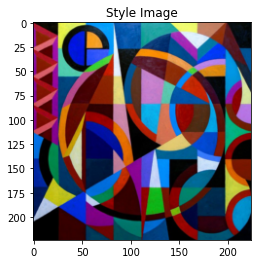

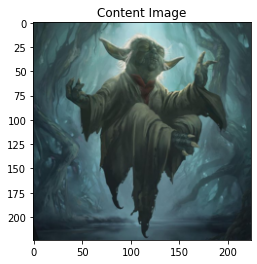

In [101]:
# Display the images
toPIL = transforms.ToPILImage()  

def display(tensor, title=None):
    image = tensor.cpu().clone()  
    image = image.squeeze(0)    
    image = toPIL(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)

plt.figure()
display(style_image, title='Style Image')

plt.figure()
display(content_image, title='Content Image')


___

### Part 1
Create a class to extract the layers needed for statistics

**TODO:**

**DONE:**

* Use the pretrained VGG in your model
* Gather statistics from the outputs of intermediate layers for the content image
* Gather statistics for the style image

In [102]:
import torchvision.models as models

class Normalization(nn.Module):
  def __init__(self, mean=torch.tensor([0.485, 0.456, 0.406]).cuda(), std=torch.tensor([0.229, 0.224, 0.225]).cuda()):
      super(Normalization, self).__init__()
      self.mean = mean.clone().detach().view(-1, 1, 1)
      self.std = std.clone().detach().view(-1, 1, 1)

  def forward(self, img):
      return (img - self.mean) / self.std

class VGGIntermediate(nn.Module):
  def __init__(self, requested=[]):
    super(VGGIntermediate, self).__init__()
    self.norm = Normalization().eval()
    self.intermediates = {}
    self.vgg = models.vgg16(pretrained=True).features.eval()
    for i, m in enumerate(self.vgg.children()):
        if isinstance(m, nn.ReLU):   # We want to set the relu layers to NOT do the relu in place. 
          m.inplace = False          # The model has a hard time going backwards on the in place functions. 
        
        if i in requested:
          def curry(i):
            def hook(module, input, output):
              self.intermediates[i] = output
            return hook
          m.register_forward_hook(curry(i))
    
  def forward(self, x):
    self.vgg(self.norm(x))  
    return self.intermediates

In [103]:
vgg_names = ["conv1_1", "relu1_1", "conv1_2", "relu1_2", "maxpool1", "conv2_1", "relu2_1", 
             "conv2_2", "relu2_2", "maxpool2", "conv3_1", "relu3_1", "conv3_2", "relu3_2", 
             "conv3_3", "relu3_3", "maxpool3", "conv4_1", "relu4_1", "conv4_2", "relu4_2", 
             "conv4_3", "relu4_3", "maxpool4", "conv5_1", "relu5_1", "conv5_2", "relu5_2", 
             "conv5_3", "relu5_3", "maxpool5"]

# Choose the layers to use for style and content transfer
content_layers = [
  vgg_names.index('conv4_2'),
]

style_layers = [
  vgg_names.index('conv1_1'), 
  vgg_names.index('conv2_1'), 
  vgg_names.index('conv3_1'), 
  vgg_names.index('conv4_1'), 
  vgg_names.index('conv5_1'),
]

# Create the vgg network in eval mode with our forward method that returns the outputs of the intermediate layers we requested
vgg_content_network = VGGIntermediate(content_layers).cuda()
vgg_style_network = VGGIntermediate(style_layers).cuda()

# Cache the outputs of the content and style layers for their respective images
content_out = vgg_content_network(content_image.cuda())
style_out = vgg_style_network(style_image.cuda())

for key, value in content_out.items():
  content_out[key] = content_out[key].clone().detach()
for key, value in style_out.items():
  style_out[key] = style_out[key].clone().detach()

content_out_list = list(content_out.values())
style_out_list = list(style_out.values())

# Print out shapes for reference
for key, value in content_out.items():
  print(f'content[{key}]\t{value.shape}')
print('')
for key, value in style_out.items():
  print(f'style[{key}]\t{value.shape}')

content[19]	torch.Size([1, 512, 28, 28])

style[0]	torch.Size([1, 64, 224, 224])
style[5]	torch.Size([1, 128, 112, 112])
style[10]	torch.Size([1, 256, 56, 56])
style[17]	torch.Size([1, 512, 28, 28])
style[24]	torch.Size([1, 512, 14, 14])


___

### Part 2
Create a classes for the style and content loss

**TODO:**

**DONE:**

* Create a module that calculates the content loss in the forward method, compared to some precalculated targets stored in the class
* Create a module that calculates the style loss in the forward method using a gram matrix, compared to some precalculated targets stored in the class

In [104]:
def gram_matrix(input):
  N = input.shape[1]
  F = input.view(N, -1)

  # (3)
  gram = torch.matmul(F, F.t())
  return gram

  
class ContentLoss(nn.Module):
  def __init__(self, ytru):
    super(ContentLoss, self).__init__()  
    N = ytru.shape[1]
    self.P = ytru.clone().detach().view(N, -1)

  def forward(self, yhat):
    N = yhat.shape[1]
    F = yhat.view(N, -1)

    # (1)
    return .5 * torch.sum(torch.square(F - self.P))

    
class StyleLoss(nn.Module):
  def __init__(self, ytru):
    super(StyleLoss, self).__init__() 
    self.A = gram_matrix(ytru.clone().detach())

  def forward(self, yhat):
    N = yhat.shape[1]
    M = yhat.shape[2] * yhat.shape[3]
    G = gram_matrix(yhat)

    # (4)
    coef = 1 / (4 * (N*N) * (M*M))
    return coef * torch.sum(torch.square(G - self.A))


# Instantiate a content loss module for each content layer 
# with the content reference image outputs for that layer for comparison
closs = [ContentLoss(ytru) for ytru in content_out_list]

# Instantiate a style loss module for each style layer 
# with the style reference image outputs for that layer for comparison
sloss = [StyleLoss(ytru) for ytru in style_out_list] 

___

### Part 3
Create and run a method that minimizes the content and style loss for a copy of the content image

Note that the content loss should be zero if you take out the style loss. Why is that?

> Answer: If you take out the style loss, then the only loss that is being accounted for is the content. The content loss is itself compared between the generated image and the original content image. The generated image starts off as a clone of the original content image, however. So, when trying to do loss without style, the MSE between the original and content image is always zero (because the generated image will never change).

**TODO:**

**DONE:**

* Use an Adam optimizer (try learning rate of .1) (I did, it didn't work well; I'm using .001 now).
* Show both the content and the style loss every 50 steps
* Ensure that the outputs don't go out of range (clamp them)
* Display the tensor as an image!

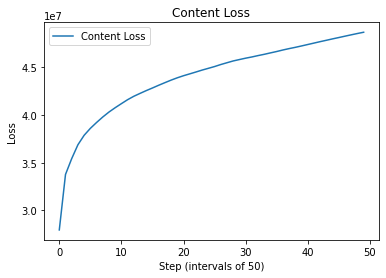

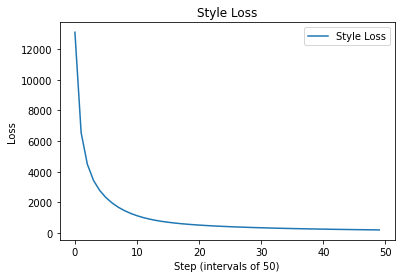

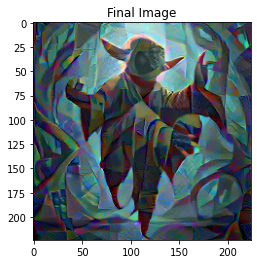

In [105]:
# Configuration
N_STEPS = 2500
N_DISPLAY = 50
LEARNING_RATE = .001

# The weights applied to the style and content images
ALPHA = 0.01
BETA = 900000

# The weights of the different content and style feature layers respectively
cw = [1]
sw = [.2, .8, .8, .8, 6]

def minimize_content_and_style_loss():
  # Start with a copy of the content image and keep track of losses
  generated_image = torch.clone(content_image)
  generated_image.requires_grad = True
  content_losses = []
  style_losses = []

  # Run the optimizer on the images to change the image using the loss of the style and content layers to backpropagate errors 
  optimizer = optim.Adam([generated_image], lr=LEARNING_RATE)

  # Run the training loop
  loop = tqdm(total=N_STEPS // N_DISPLAY, position=0, leave=False)
  for i in range(N_STEPS):
    total_content_loss = torch.zeros((1)).cuda()
    total_style_loss = torch.zeros((1)).cuda()

    # Get the loss for the content image compared to the generated image
    gen_content_out = vgg_content_network(generated_image)
    gen_content_out_list = list(gen_content_out.values())
    for j in range(len(gen_content_out_list)):
      yhat = gen_content_out_list[j]
      total_content_loss += closs[j](yhat) * cw[j]

    # (5)
    # Get the loss for the style image compared to the generated image
    gen_style_out = vgg_style_network(generated_image)
    gen_style_out_list = list(gen_style_out.values())
    for j in range(len(gen_style_out_list)):
      yhat = gen_style_out_list[j]
      total_style_loss += sloss[j](yhat) * sw[j]

    # Update the generated image
    optimizer.zero_grad()
    total_loss = ALPHA * total_content_loss + BETA * total_style_loss
    total_loss.backward()
    optimizer.step()

    # Track progess every N_DISPLAY steps
    if (i + 1) % N_DISPLAY == 0:
      tot_content_item = total_content_loss.item()
      tot_style_item = total_style_loss.item()
      loop.set_description(f'step={i + 1}, content_loss={tot_content_item:.3f}, style_loss={tot_style_item:.3f}')
      loop.update(1)
      content_losses.append(tot_content_item)
      style_losses.append(tot_style_item)

  # Finish the loop
  loop.close()
  return generated_image, content_losses, style_losses

# Do style transfer loop
generated_image, content_losses, style_losses = minimize_content_and_style_loss()

# Show the content and style loss
plt.title('Content Loss')
plt.plot(content_losses, label='Content Loss')
plt.xlabel(f'Step (intervals of {N_DISPLAY})')
plt.ylabel('Loss')
plt.legend()
plt.show()
  
plt.title('Style Loss')
plt.plot(style_losses, label='Style Loss')
plt.xlabel(f'Step (intervals of {N_DISPLAY})')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Show the image (clamp the outputs so they don't go out of range)
plt.figure()
display(torch.clamp(generated_image, 0, 1), title='Final Image')

### Part 4

**TODO:**

**DONE:**

- Describe equation (1) on p. 10 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
  - This is the loss for the content (`Lcontent`). It represents the mean squared error between the features of the original image `P` and the generated image `F` (features are extracted from VGG). It is multiplied by 1/2 to account for the derivative later down the line during computation.
    - `p` is the original image.
    - `x` is the generated image.
    - `l` is the index of the layer into the VGG model (for extracting features at a specific layer).
    - `i` is the index of the filter (channel) into the current layer `l`.
    - `j` is the index of the element into the "flattened" version of the height/width dimensions of the layer `l`.
    - `Fij` is the generated image features at row `i` column `j` flattened into an MxN matrix, where `M` is the height times the width of the feature map and `N` is the number of filters (channels).
    - `Pij` is similar to `Fij`, except it is the features for the original image.
    - The difference between `Fij` and `Pij` is summed up and squared (MSE).


- Describe equation (3) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
  - This is the gram matrix for a vectorized feature map. It is of size `NxN` because it is the inner product between vectorized feature maps. It represents the correlations (similarity) between different filter responses. This can easily be computed by dotting a feature map with its transpose.
    - `Gij` is the is inner product between vectorized feature maps `i` and `j` in layer `l`.
    - `Fik` is a value take from a `MxN` vectorized feature map. It is taken at channel `i` and height/width element `k` taken from layer `l`.
    - `Fjk` is a value take from a `MxN` vectorized feature map. It is taken at channel `k` and height/width element `k` taken from layer `l`. Multiplying this with `Fik` is altogether multiplying a matrix with its transpose.


- Describe equation (4) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
  - This is the style loss for one particular layer from the generated image compared to the style image. It is the mean squared error between the gram matrices of both the generate image features and the style image features multiplied by some constant `1/(4*M*M*N*N)`. This will help find an image that correlates well with the style representation of the original image.
    - `Gij` is the `ith` row of the `jth` column of the gram matrix resulting from the feature map at layer `l` of the generated image.
    - `Aij` is the `ith` row of the `jth` column of the gram matrix resulting from the feature map at layer `l` of the original style image.
    - The difference between all `Gij` and `Aij` elements is summed up an squared (MSE).
    - `M` is the height times the width of the feature map and `N` is the number of filters (channels).
    - `1/(4*M*M*N*N)` is similarly a constant in this secenario, it scales the result of the gram matrix down. If you left this out, you would just have to adjust your alpha and beta later down the line when summing up content loss.

- Describe equation (5) on p. 11 of (Gatys 2016) in plain English, including the meaning of all variables and subscripts.
  - This is the loss of the style between the original style image `a` and the generated image `x`. The total loss of the style is the sum of the losses of all "used" style feature layers taken from passing the style and generated images into the VGG model (see equation 4 description). This is done over each layer `l`. Each layer's style loss `El` is multiplied by some weight `wl` before it is summed up. This will help provide biases for particular layers.

Note to myself: All these losses are summed up at the end. The style loss is multiplied by some constant B and the content loss is multiplied by some constant A. These will help bias towards content or style.